In [1]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [2]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20210923-193932_c2e2466f153fd677fc77778d2775d1d8'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [3]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [5]:
example_id = 1

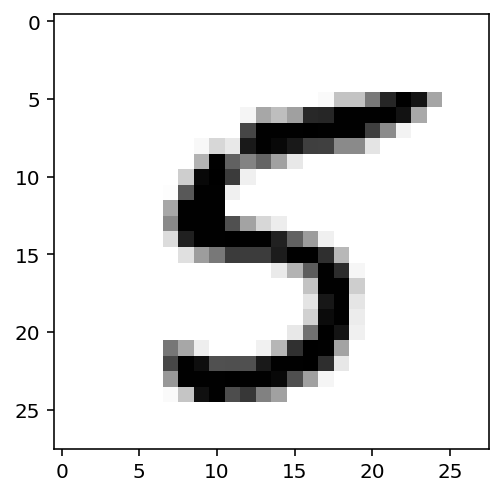

In [6]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

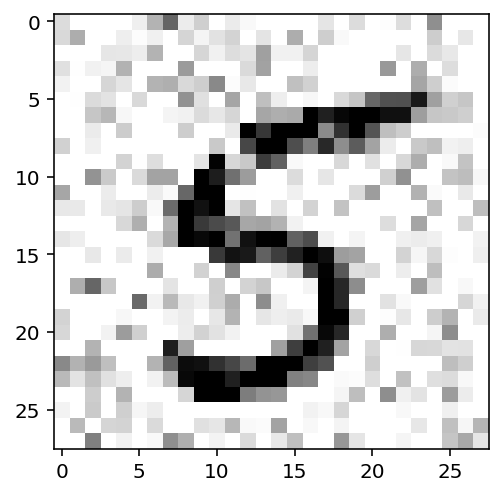

In [7]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [8]:
train_y.iloc[example_id]

digit    5
Name: 1, dtype: uint8

In [9]:
# # Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-10-01 18:11:50.846153: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-01 18:11:50.894400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 18:11:50.895283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-01 18:11:50.895565: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-01 18:11:50.897625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-01 18:11:50.899688: I tensorflow/stream_executor/platform/defaul

In [12]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

# Your work from here forward (please document your code as much as possible)

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp: HyperParameters):
    
    layers = [
        # encoder: variable number of nodes, exponential linear unit activation, l1 regularization
        Dense(
            units=hp.Int('encoder_width', min_value=184, max_value=1384, step=100, default=784), 
            activation=hp.Choice('activation', ['elu', 'relu']),
            activity_regularizer=regularizers.l1(hp.Float('rglrz_param', min_value=1e-5, max_value=2e-4,
                                                           sampling='log', default=1e-4)), 
            input_shape=(28 * 28,)
        ),

        # decoder: matches the shape of the image
        # sigmoid activation is needed because pixel values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    autoencoder = Sequential(layers)

    # using MSE as the loss function, and Adam optimizer
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [13]:
from tensorflow.keras import callbacks

def train_model(model, epochs):
    history = model.fit(
        
        # for denoising mode, we need x to be x_train_noisy and y to be x_train_clean
        # similarly, the validation data should be (x_test_noisy, x_test_clean)
        
        x=train_noisy_X, 
        y=train_clean_X,

        # in general, we'll use a low number of epochs to test the learning process
        # but not for the final model training
        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X),
        callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    )
    return history

In [14]:
# set the seed values for numpy and tensorflow to get reproducible results
import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

hp = HyperParameters()
hp.Fixed('encoder_width', value=100)
hp.Fixed('learning_rate', value=0.001)

autoencoder = build_model(hp)
history = train_model(autoencoder, epochs=20)

2021-10-01 18:19:15.518256: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-01 18:19:15.543214: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300015000 Hz
2021-10-01 18:19:15.543533: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564e4f08eaf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-01 18:19:15.543554: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-01 18:19:15.543951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 18:19:15.544812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tes

Epoch 1/20
  1/383 [..............................] - ETA: 0s - loss: 0.2382

2021-10-01 18:19:17.539431: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


383/383 [==============================] - 2s 4ms/step - loss: 0.0549 - val_loss: 0.0317
Epoch 2/20
383/383 [==============================] - 1s 4ms/step - loss: 0.0266 - val_loss: 0.0228
Epoch 3/20
383/383 [==============================] - 2s 4ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 4/20
383/383 [==============================] - 1s 4ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 5/20
383/383 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 6/20
383/383 [==============================] - 1s 4ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 7/20
383/383 [==============================] - 1s 4ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 8/20
383/383 [==============================] - 1s 4ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 9/20
383/383 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 10/20
383/383 [==============================] - 1s 4ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 11/2

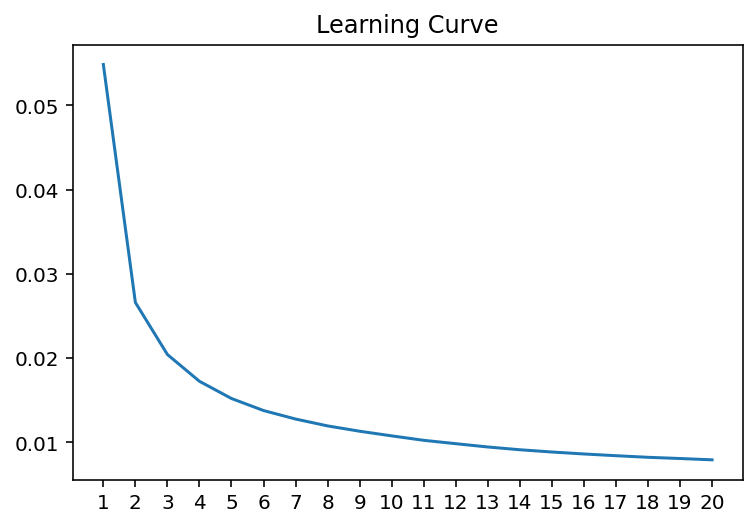

In [15]:
# fit method returns a history object that can be used to plot the learning curve

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

In [16]:
from kerastuner.tuners import RandomSearch

# sample hyperparameter values from distribution specified in the build_model function

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_04'
)

# display which hyperparameters are tunable and their respective distribution.
tuner.search_space_summary()

Search space summary
Default search space size: 4
encoder_width (Int)
{'default': 784, 'conditions': [], 'min_value': 184, 'max_value': 1384, 'step': 100, 'sampling': None}
activation (Choice)
{'default': 'elu', 'conditions': [], 'values': ['elu', 'relu'], 'ordered': False}
rglrz_param (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0002, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [17]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

tuner.search(    
    # all parameters here are passed thru to Model.fit
    x=train_noisy_X, 
    y=train_clean_X, 

    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

Trial 30 Complete [00h 00m 56s]
val_loss: 0.01841103285551071

Best val_loss So Far: 0.006223892793059349
Total elapsed time: 00h 29m 44s
INFO:tensorflow:Oracle triggered exit


In [18]:
# view the search summary
tuner.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_04
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_width: 684
activation: elu
rglrz_param: 2.4826139634487908e-05
learning_rate: 0.0012591788588148666
Score: 0.006223892793059349
Trial summary
Hyperparameters:
encoder_width: 1284
activation: elu
rglrz_param: 1.5153310206126008e-05
learning_rate: 0.003431502896648394
Score: 0.0064226531734069186
Trial summary
Hyperparameters:
encoder_width: 484
activation: elu
rglrz_param: 2.807410277588932e-05
learning_rate: 0.0030679870060080845
Score: 0.006450296690066655
Trial summary
Hyperparameters:
encoder_width: 1184
activation: elu
rglrz_param: 1.954656789779701e-05
learning_rate: 0.00429989165670032
Score: 0.007099082538237174
Trial summary
Hyperparameters:
encoder_width: 284
activation: relu
rglrz_param: 2.736413822683945e-05
learning_rate: 0.002105018859516814
Score: 0.007186968966076772
Trial summary
Hyperparameters:
encoder_wid

In [19]:
# use the tuner's oracle property can be used to fetch information about every trial

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,activation,rglrz_param,learning_rate
trial_id,,,,,
765808b3725b99bdd8688e558d78c179,0.006224,684,elu,0.000025,0.001259
13996a5ee5804439ae4354e79af9eade,0.006423,1284,elu,0.000015,0.003432
b32ae6de4bb694c2e1e890b6ccc1a90d,0.006450,484,elu,0.000028,0.003068
9f5f9afa07b3e5acd8ab6a83f8d74ccb,0.007099,1184,elu,0.000020,0.004300
f9a2a830c2202353c3b27c796f2f082d,0.007187,284,relu,0.000027,0.002105
87cccbb40fab866155552f328de81334,0.007338,784,elu,0.000047,0.002025
77435afc0997c87a82bf53d7ccc2eab1,0.007425,584,relu,0.000033,0.004342
37b71a24d835966c4b1e836f7c018fa8,0.008113,284,elu,0.000011,0.000237
639926eb4a67ccb2aba173a7ab423129,0.008734,484,relu,0.000018,0.013081


In [20]:
# returns the best model found during the search
autoencoder = tuner.get_best_models(num_models=1)[0]

In [21]:
# display best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values

{'encoder_width': 684,
 'activation': 'elu',
 'rglrz_param': 2.4826139634487908e-05,
 'learning_rate': 0.0012591788588148666}

In [22]:
# FINAL TRAINING PASS WITH OPTIMAL HYPERPARAMETERS

np.random.seed(11)
tf.random.set_seed(11)

hp = HyperParameters()

hp.Fixed('encoder_width', value=684)
hp.Fixed('activation', value='elu')
hp.Fixed('rglrz_param', value=2.4826139634487908e-05)
hp.Fixed('learning_rate', value=0.0012591788588148666)

autoencoder = build_model(hp)
history = train_model(autoencoder, epochs=300)

Epoch 1/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0272 - val_loss: 0.0133
Epoch 2/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 3/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 4/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 5/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 6/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 7/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 8/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 9/300
383/383 [==============================] - 2s 5ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 10/300
383/383 [==============================] - 3s 7ms/step - loss: 0.0061 - val_lo

In [23]:
# now we can feed the noisy images into the autoencoder
train_denoised_X = autoencoder.predict(train_noisy_X)

# keras returns back a numpy array, but we need pandas dataframe,
# so let's quickly put the denoised images into a dataframe
train_denoised_X = pd.DataFrame(train_denoised_X)

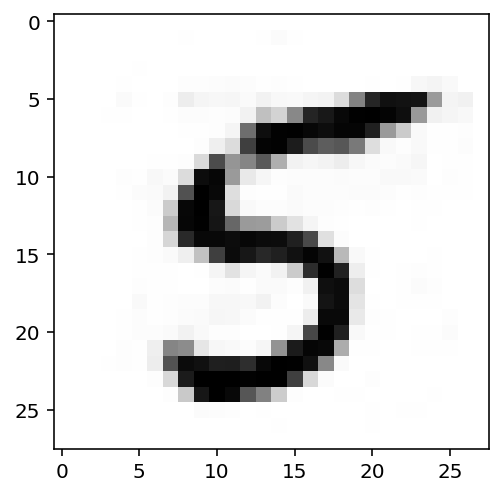

In [24]:
# confirm that the denoiser works
image_pixels = train_denoised_X.iloc[example_id]

# to plot an image, need to reshape the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error

# calcualate MSE on train clean against train denoised
print(mean_squared_error(train_denoised_X, train_clean_X))

# calcualates MSE on test clean against test denoised
test_denoised_X = autoencoder.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
print(mean_squared_error(test_denoised_X, test_clean_X))

0.0031937542
0.0036333748


A noisy image from the test dataset:

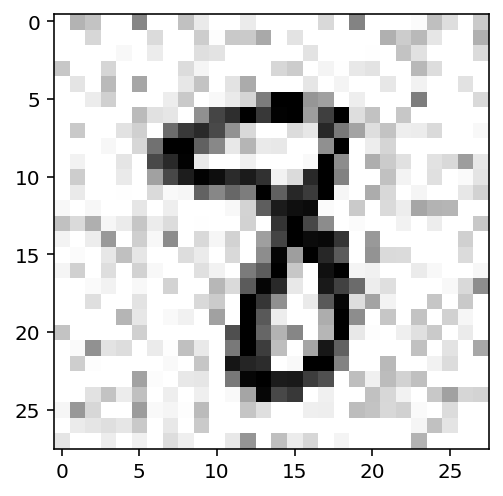

In [26]:
image_pixels = test_noisy_X.iloc[example_id]
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

The same clean image from the test dataset:

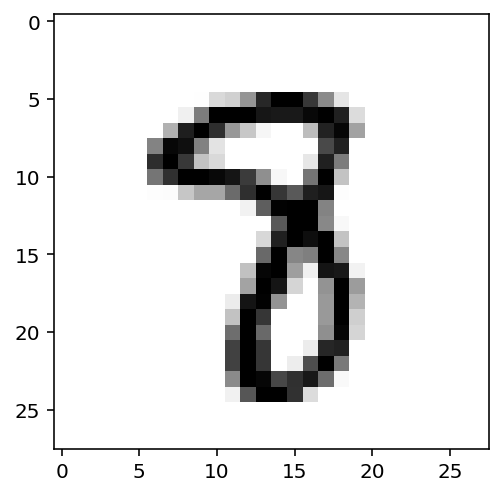

In [27]:
image_pixels = test_clean_X.iloc[example_id]
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

The same denoised image from the test dataset:

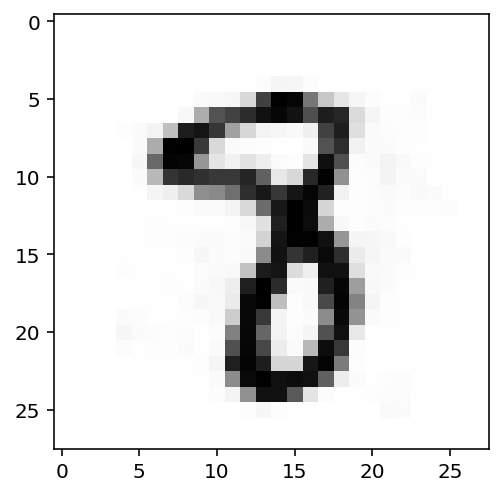

In [28]:
image_pixels = test_denoised_X.iloc[example_id]
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [29]:
# Once you have finished building your model and are satisfied with your results,
# run the code below to save the files necessary for submission.

import os 

model_dir = 'denoiser_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_dir}/score_denoised_x.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(autoencoder.to_json()), indent=True))

# Finally, let's save the learned parameters.
autoencoder.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset